# Problem Statement

> **QUESTION**: ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, **you're tasked with creating an automated system to estimate the annual medical expenditure for new customers**, using information such as their age, sex, BMI, children, smoking habits and region of residence.
>
> Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to regulatory requirements, you must be able to explain why your system outputs a certain prediction.
>
> You're given a [CSV file](https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv) containing verified historical data, consisting of the aforementioned information and the actual medical charges incurred by over 1300 customers.
> <img src="https://i.imgur.com/87Uw0aG.png" width="480">
>
> Dataset source: https://github.com/stedy/Machine-Learning-with-R-datasets








Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import cufflinks as cf  # Cufflinks is used to show the plotly plot in the Jupyter notebook
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# To show the plotly plot in the Jupyter notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
# Initialize plotly notebook mode
init_notebook_mode(connected=True)
cf.go_offline()

# Scikit-Learn (Traditional Machine Learning)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score

# Scikit-Learn ML Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import warnings 
warnings.filterwarnings('ignore')

# import gc
# from tqdm.notebook import tqdm 


# for i in tqdm(range(100)):
#     pass

## Reading the Dataset

In [2]:
df=pd.read_csv('insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Plotting General Information

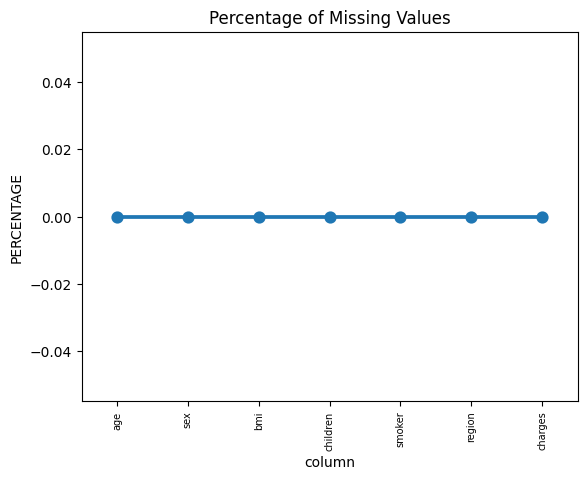

In [6]:
missing = pd.DataFrame((df.isnull().sum()) * 100 / df.shape[0]).reset_index()
missing.columns = ['column', 'percentage']

# Plot the missing values
ax = sns.pointplot(x='column', y='percentage', data=missing)
plt.xticks(rotation=90, fontsize=7)
plt.title("Percentage of Missing Values")
plt.ylabel("PERCENTAGE")
plt.show()

> No Missing Values

### Object Datatypes

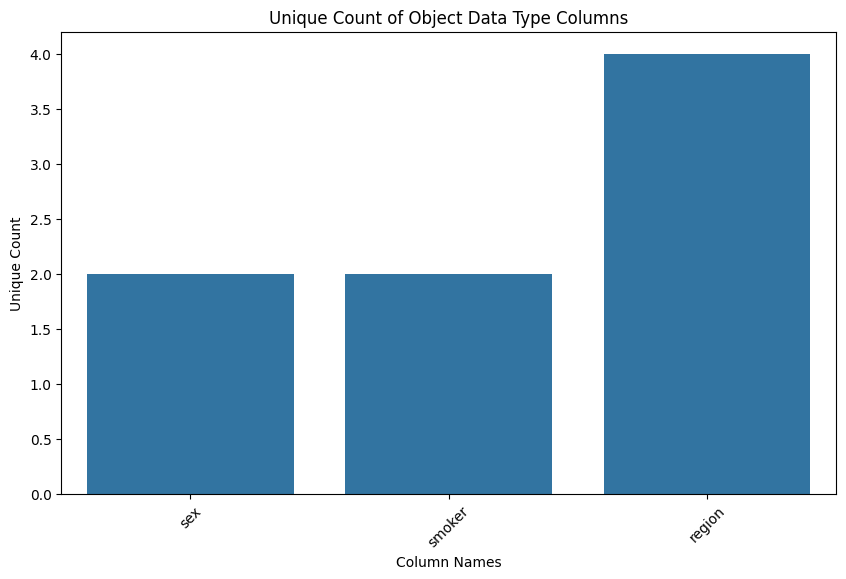

In [7]:
object_columns = df.select_dtypes(include=['object']).columns
num_columns = df.select_dtypes(include=['int64', 'float64']).columns
# Count the unique values for each object column
unique_counts = df[object_columns].nunique()

# Convert the Series to a DataFrame for easier plotting with Seaborn
unique_counts_df = unique_counts.reset_index()
unique_counts_df.columns = ['Column', 'Unique Count']

# Plotting the graph
plt.figure(figsize=(10, 6))
sns.barplot(x='Column', y='Unique Count', data=unique_counts_df)
plt.xlabel('Column Names')
plt.ylabel('Unique Count')
plt.title('Unique Count of Object Data Type Columns')
plt.xticks(rotation=45)
plt.show()

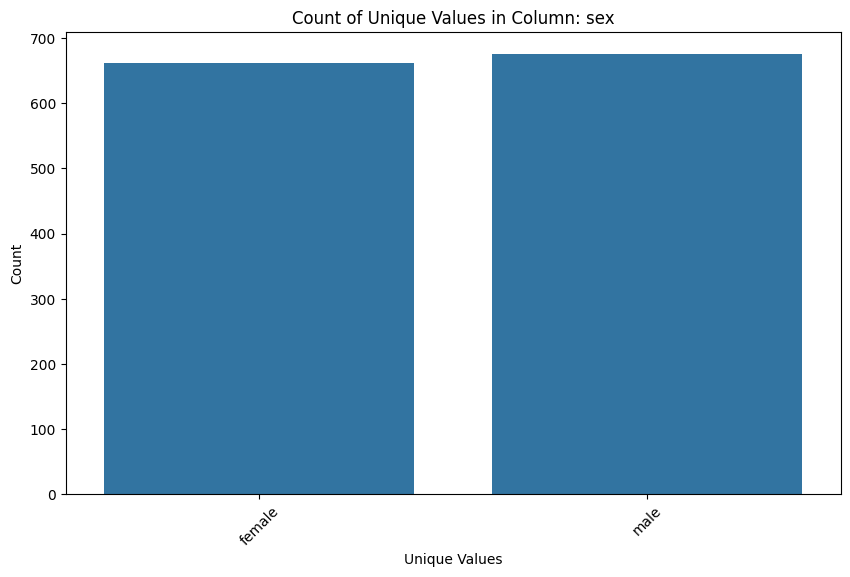

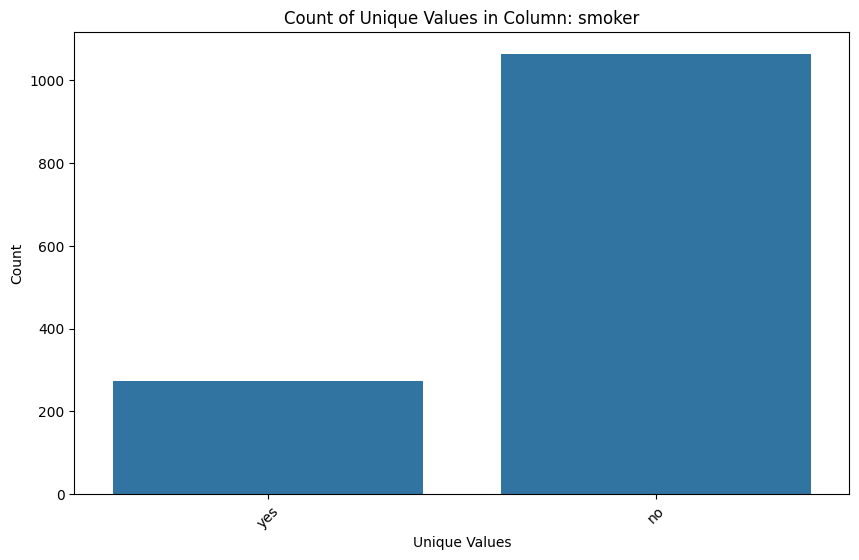

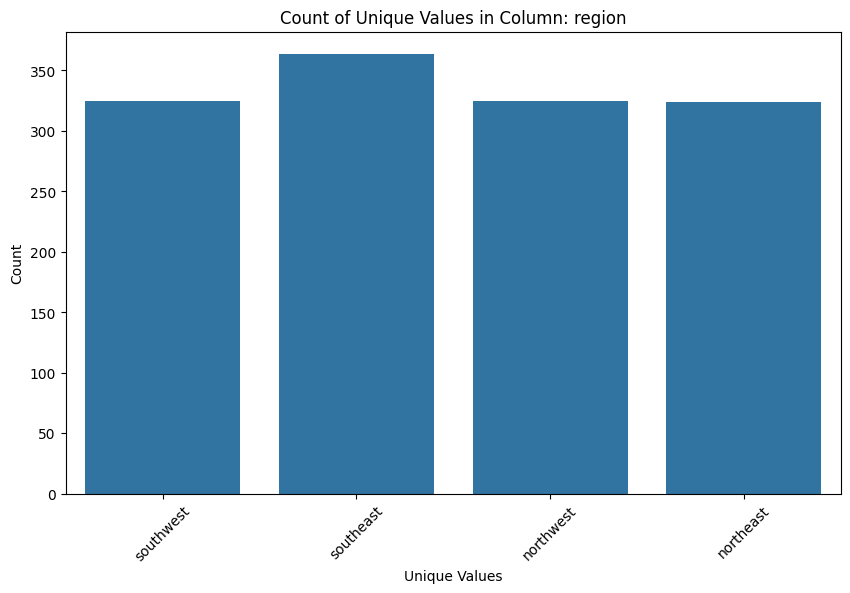

In [8]:
for column in object_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data=df)
    plt.xlabel('Unique Values')
    plt.ylabel('Count')
    plt.title(f'Count of Unique Values in Column: {column}')
    plt.xticks(rotation=45)
    plt.show()

### Object Datatype Info:
- Males and Female are equally likely to get the insurance done
- Smokers are predominant in the dataset
- Among all the regions Southeast region gives more clients

### Numerical Datatype

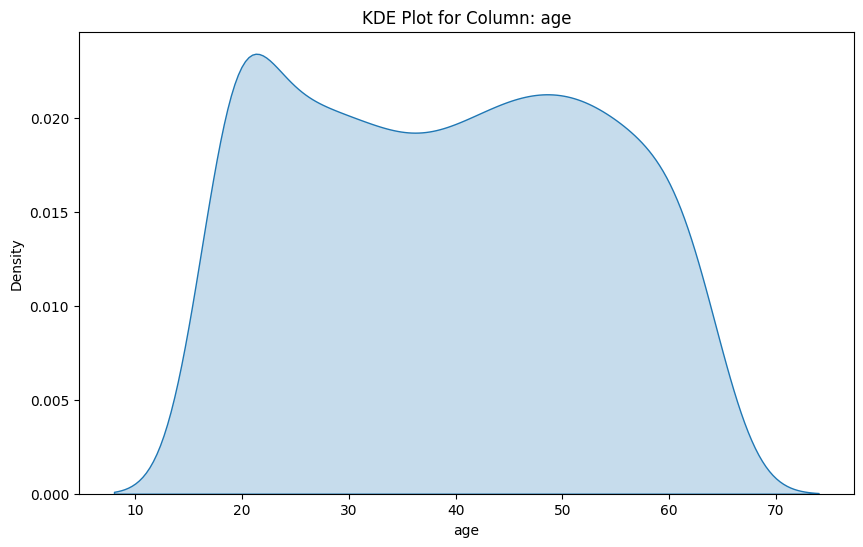

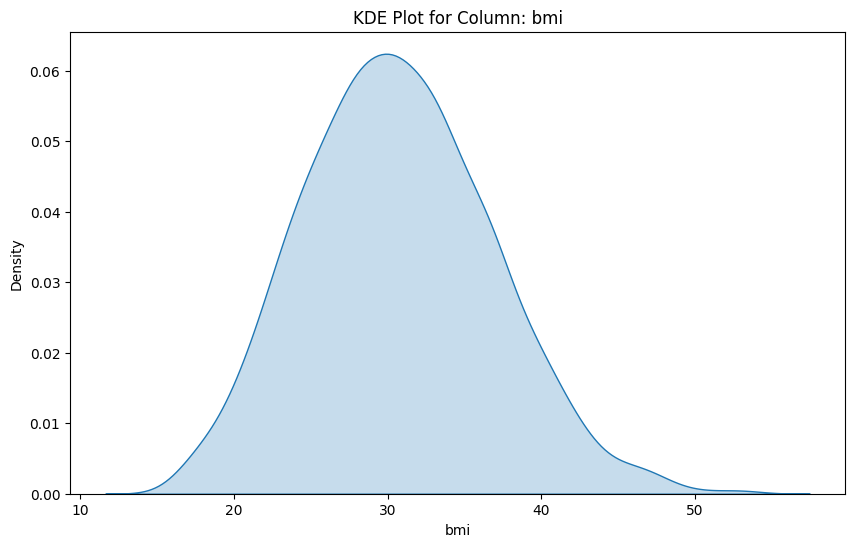

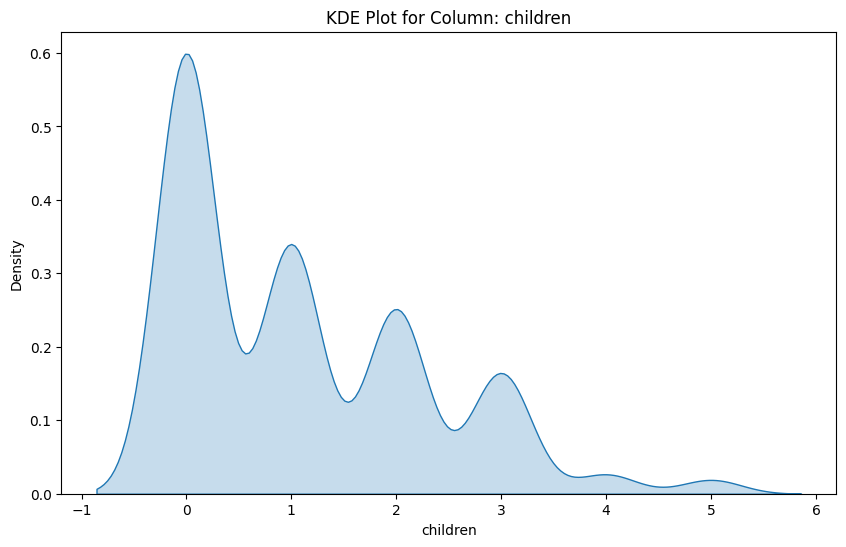

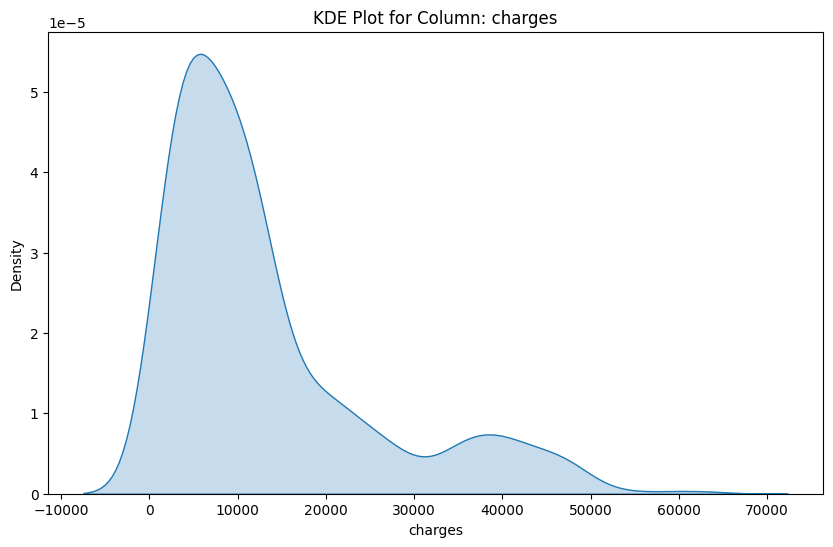

In [9]:
for column in num_columns:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df[column], shade=True)
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.title(f'KDE Plot for Column: {column}')
    plt.show()

### Numerical Datatypes Info:
- Right Skewness in Charge implies most people fall under 30000 marks
- Age is well Distributed
- BMI shows Normal distribution with average of 25  to 30 showing over weight

<Axes: ylabel='charges'>

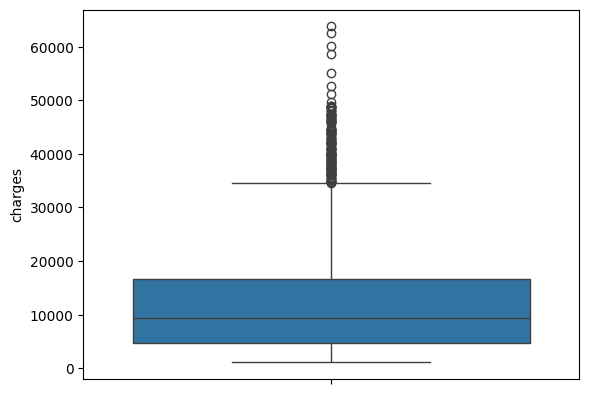

In [10]:
sns.boxplot(df['charges'])

<Axes: xlabel='charges', ylabel='Density'>

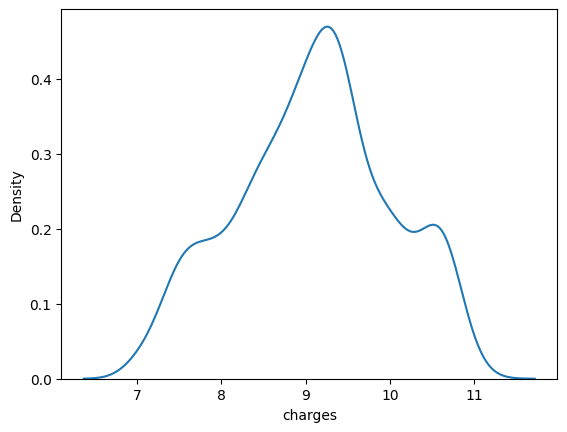

In [11]:
sns.kdeplot(np.log(df['charges']))

<Axes: ylabel='charges'>

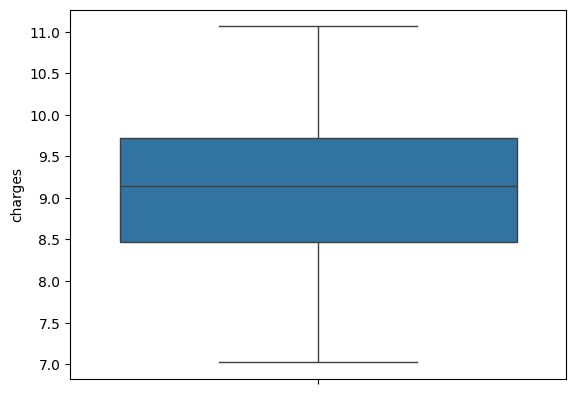

In [12]:
sns.boxplot(np.log(df['charges']))

In [13]:
df['log_charges']=np.log(df['charges'])

In [14]:
df_num=df.select_dtypes(include=['int64','float64'])
df_num.head()

,age,bmi,children,charges,log_charges
0,19,27.900,0,16884.92400,9.734176
1,18,33.770,1,1725.55230,7.453302
2,28,33.000,3,4449.46200,8.400538
3,33,22.705,0,21984.47061,9.998092
4,32,28.880,0,3866.85520,8.260197


In [15]:
df_corr=df_num.corr()

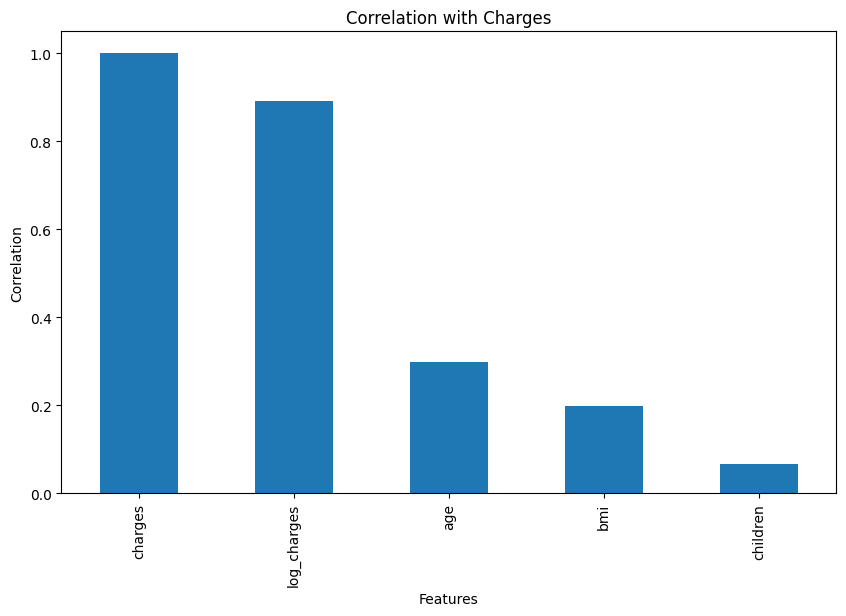

In [16]:
plt.figure(figsize=(10, 6))
df_corr['charges'].sort_values(ascending=False).plot(kind='bar')
plt.title('Correlation with Charges')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

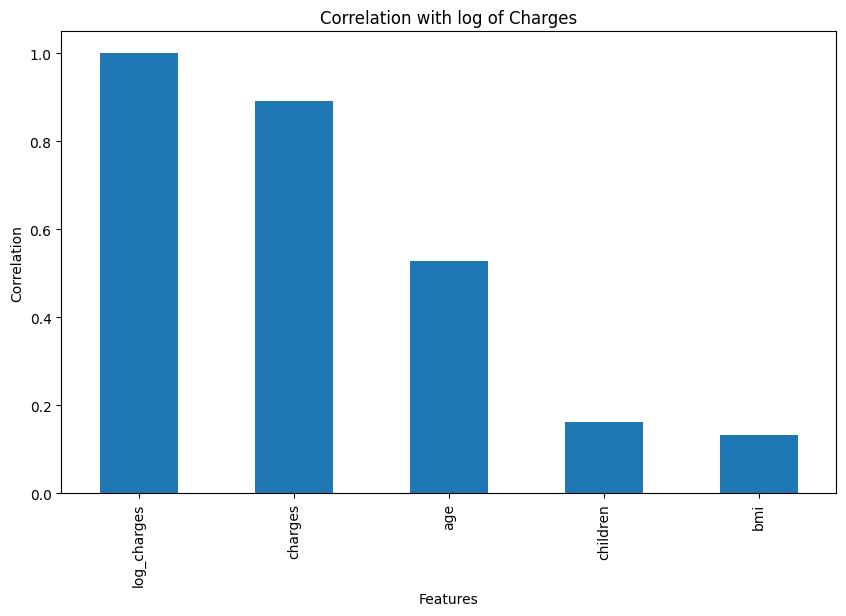

In [17]:
plt.figure(figsize=(10, 6))
df_corr['log_charges'].sort_values(ascending=False).plot(kind='bar')
plt.title('Correlation with log of Charges')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

Although Correlation is not causation but its quite evident that age and bmi plays important role in charges,
also log_charges has better distribution so the effect of age is more prominent 

### Univariate Analysis on Numerical Column

<Axes: xlabel='age', ylabel='charges'>

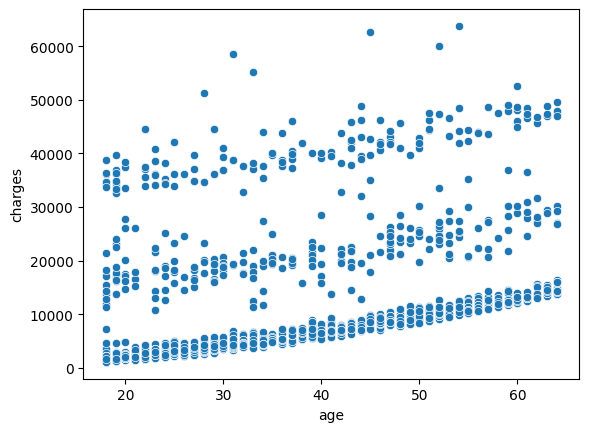

In [18]:
sns.scatterplot(data=df, x='age', y='charges')

<Axes: xlabel='bmi', ylabel='charges'>

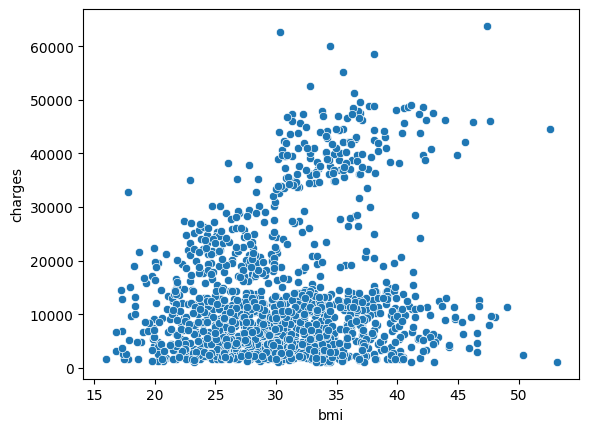

In [19]:
sns.scatterplot(data=df, x='bmi', y='charges')

### Univariate Analysis on Categorical Column

<Axes: xlabel='smoker', ylabel='charges'>

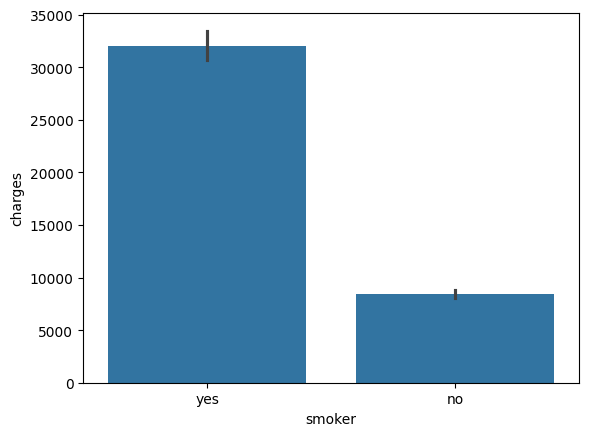

In [20]:
sns.barplot(data=df, x='smoker', y='charges')

<Axes: xlabel='children', ylabel='charges'>

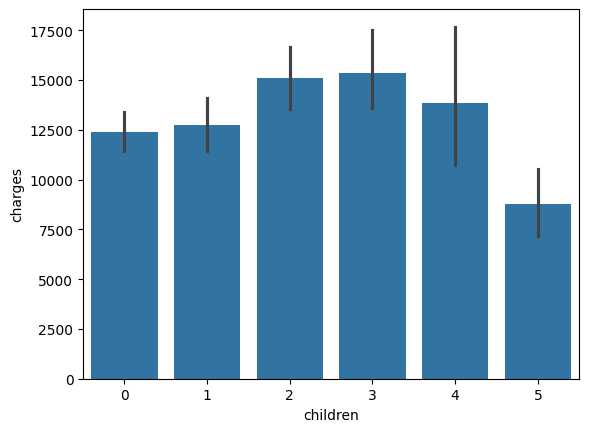

In [21]:
sns.barplot(data=df, x='children', y='charges')

<Axes: xlabel='sex', ylabel='charges'>

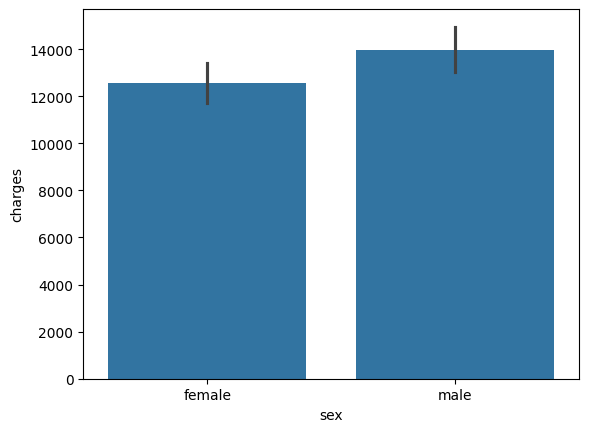

In [22]:
sns.barplot(data=df, x='sex', y='charges')

### Conclusion for Uni Variate Analysis
- Male are charged more than the females
- Smokers are charged wayy more than the non smokers
- Charges increased with the age , so they are directly proportional
- BMI has lots of outliers but in general people with higher bmi are charged more, though there are some exceptions maybe because of age or smoking habit

In [23]:
print("Smokers Median :")
print(df[df['smoker'] == 'yes']['charges'].median())
print("-----------------------------------------------------------")
print("Non-Smokers Median :")
print(df[df['smoker'] == 'no']['charges'].median())
print("-----------------------------------------------------------")
print("Male Median :")
print(df[df['sex'] == 'male']['charges'].median())
print("-----------------------------------------------------------")
print("Female Median :")
print(df[df['sex'] == 'female']['charges'].median())
print("-----------------------------------------------------------")
print("Median by Region :")
print("southwest:")
print(df[df['region'] == 'southwest']['charges'].median())
print("-----------------------------------------------------------")
print("southeast:")
print(df[df['region'] == 'southeast']['charges'].median())
print("-----------------------------------------------------------")
print("northwest:")
print(df[df['region'] == 'northwest']['charges'].median())
print("-----------------------------------------------------------")
print("northeast :")
print(df[df['region'] == 'northeast']['charges'].median())



Smokers Median :
34456.348450000005
-----------------------------------------------------------
Non-Smokers Median :
7345.4053
-----------------------------------------------------------
Male Median :
9369.61575
-----------------------------------------------------------
Female Median :
9412.9625
-----------------------------------------------------------
Median by Region :
southwest:
8798.593
-----------------------------------------------------------
southeast:
9294.131949999999
-----------------------------------------------------------
northwest:
8965.79575
-----------------------------------------------------------
northeast :
10057.652025


### Observations

> The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages. The uniform distribution might arise from the fact that there isn't a big variation in the number of people of any given age (between 18 & 64) in the USA.

> The measurements of body mass index seem to form a Gaussian distribution centered around the value 30

>Northeast has highest Median while southwest is having lowest

>Smokers have higher median

>Females have higher median



### Multivariate Analysis

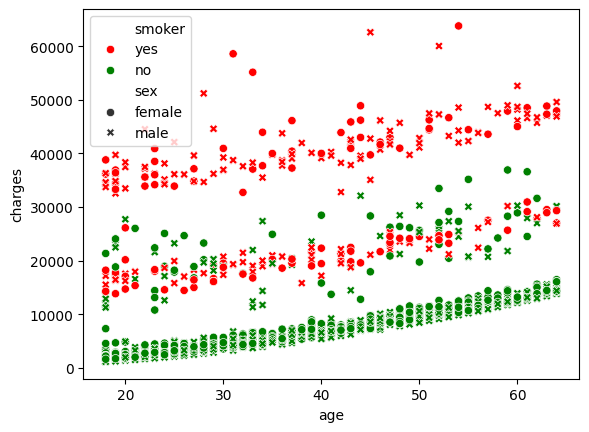

In [35]:
palette = {'yes': 'red', 'no': 'green'}
sns.scatterplot(data=df, x='age', y='charges', hue='smoker', style='sex', palette=palette)
plt.show()

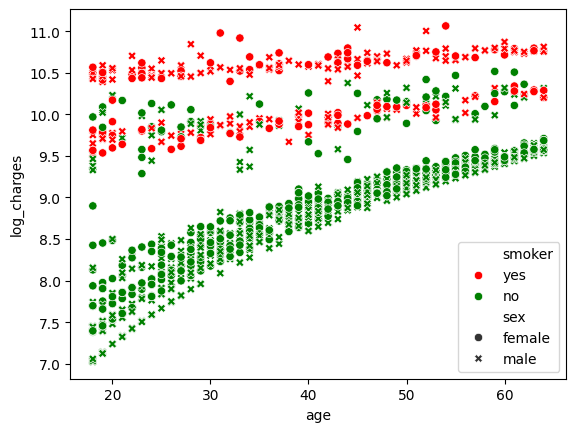

In [36]:
sns.scatterplot(data=df, x='age', y='log_charges', hue='smoker', style='sex', palette=palette)
plt.show()

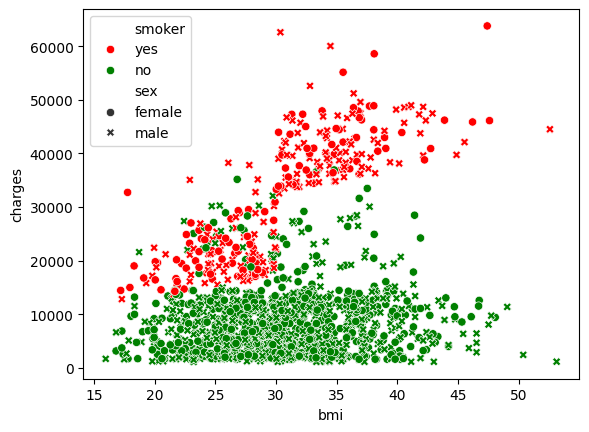

In [37]:
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker', style='sex', palette=palette)
plt.show()

<Axes: xlabel='children', ylabel='charges'>

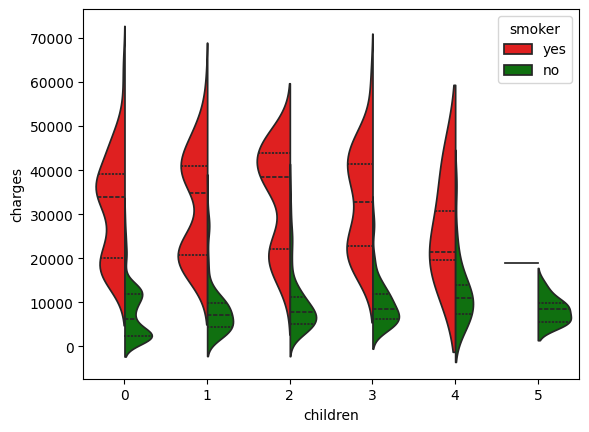

In [39]:
sns.violinplot(data=df, x='children', y='charges', hue='smoker', split=True, inner="quart",palette=palette)


<Axes: xlabel='region', ylabel='charges'>

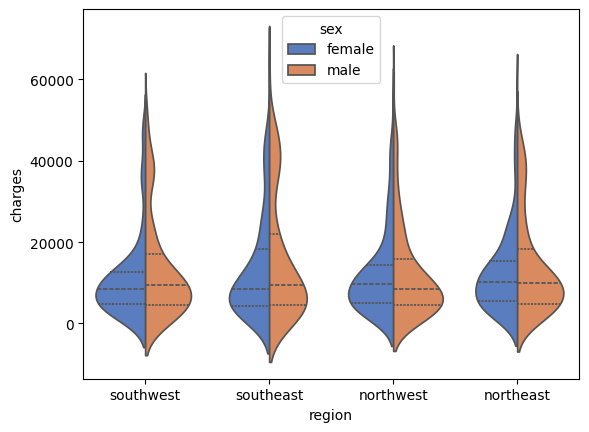

In [41]:
sns.violinplot(data=df, x='region', y='charges', hue='sex', split=True, inner="quart", palette="muted")


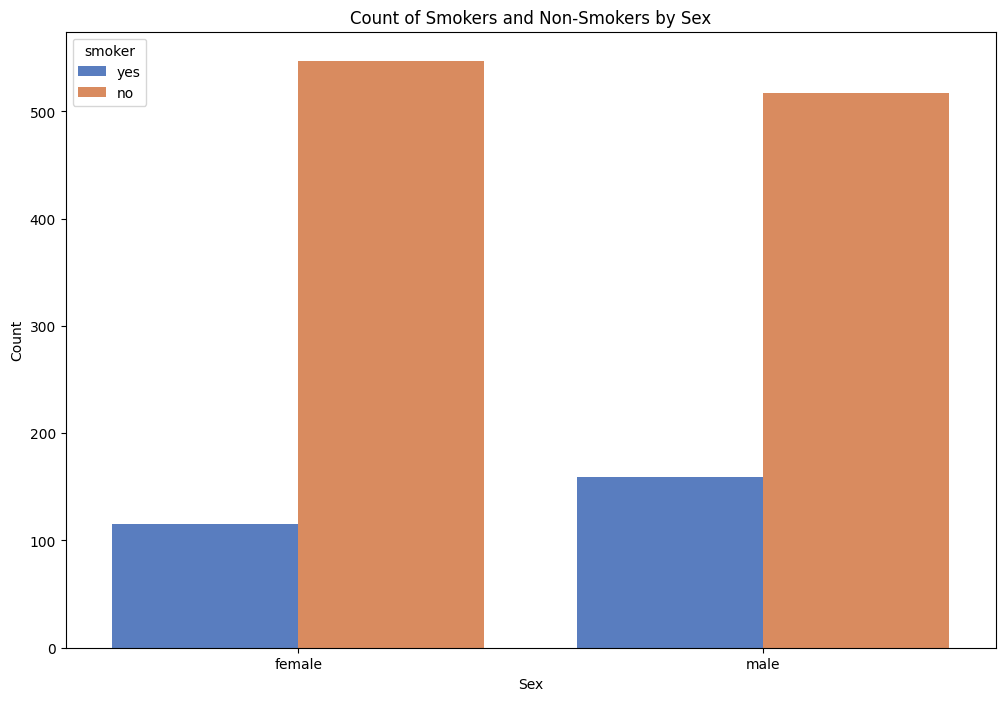

In [46]:
plt.figure(figsize=(12, 8))

sns.countplot(x='sex', hue='smoker', data=df,palette='muted') 
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Count of Smokers and Non-Smokers by Sex')
plt.show()

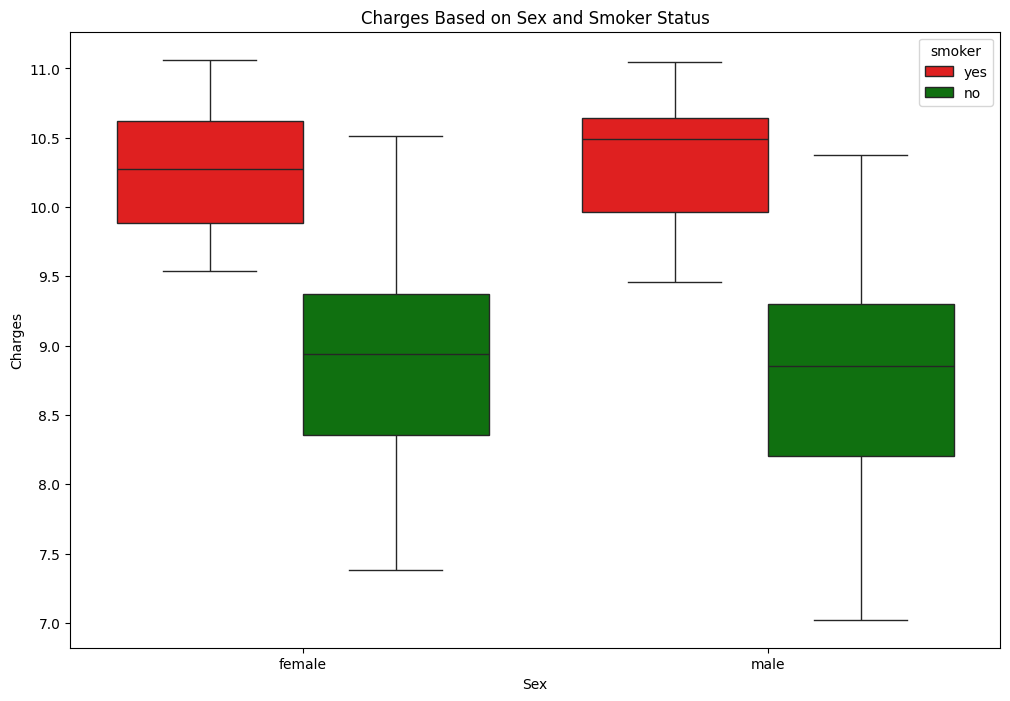

In [47]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='sex', y='log_charges', hue='smoker', data=df, palette=palette)
plt.xlabel('Sex')
plt.ylabel('Charges')
plt.title('Charges Based on Sex and Smoker Status')
plt.show()

<Axes: >

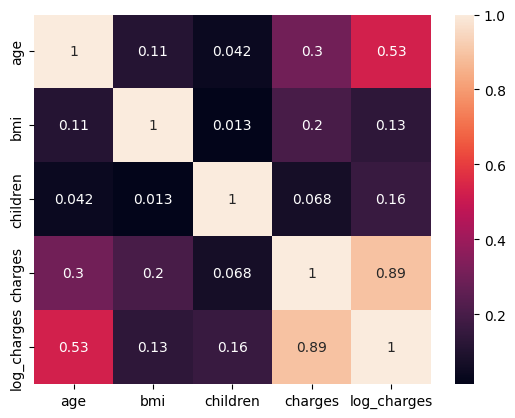

In [31]:
sns.heatmap(df_corr, annot=True)


### Observations for Multivariate Analysis
- With increase in age the charges increases also the smokers are charged more for any age group. There are 3 layers for it
    - NonSmokers  are charged least , but charges increases with age
    - Smokers and people with mild heath issues are present in the middle layer
    - Third Layer is for smokers with health issues

- Similarily in BMI non smokers are charged less than that of smoker , also the charges are more for overweight and obese individuals, and charges skyrockets for the obese smokers

- Smokers with childrens are charged more

- There are more female smokers than the male smokers

In [32]:
female_median_charges = df[df['sex'] == 'female']['charges'].median()
female_smoker_median_charges = df[(df['sex'] == 'female') & (df['smoker'] == 'yes')]['charges'].median()
female_non_smoker_median_charges = df[(df['sex'] == 'female') & (df['smoker'] == 'no')]['charges'].median()

male_median_charges = df[df['sex'] == 'male']['charges'].median()
male_smoker_median_charges = df[(df['sex'] == 'male') & (df['smoker'] == 'yes')]['charges'].median()
male_non_smoker_median_charges = df[(df['sex'] == 'male') & (df['smoker'] == 'no')]['charges'].median()

print("Female :")
print(f'Female Median Charges: {female_median_charges}')
print(f'Female Smoker Median Charges: {female_smoker_median_charges}')
print(f'Female Non-Smoker Median Charges: {female_non_smoker_median_charges}')
print("---------------------------------------------------------------------------------")
print("Male :")
print(f'Male Median Charges: {male_median_charges}')
print(f'Male Smoker Median Charges: {male_smoker_median_charges}')
print(f'Male Non-Smoker Median Charges: {male_non_smoker_median_charges}')

Female :
Female Median Charges: 9412.9625
Female Smoker Median Charges: 28950.4692
Female Non-Smoker Median Charges: 7639.41745
---------------------------------------------------------------------------------
Male :
Male Median Charges: 9369.61575
Male Smoker Median Charges: 36085.219
Male Non-Smoker Median Charges: 6985.50695


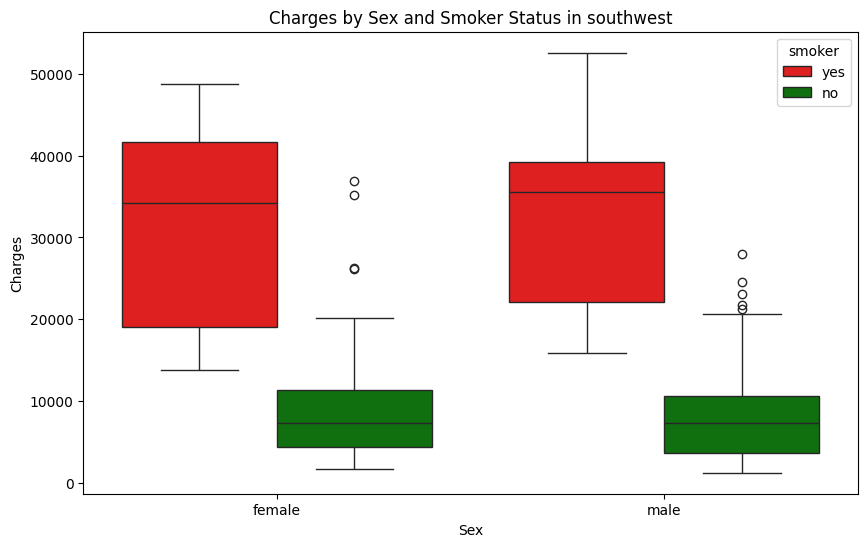

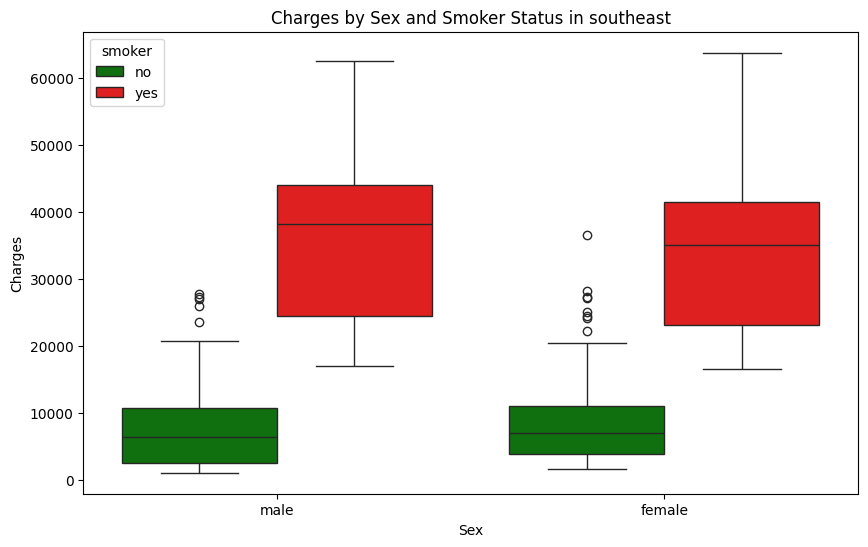

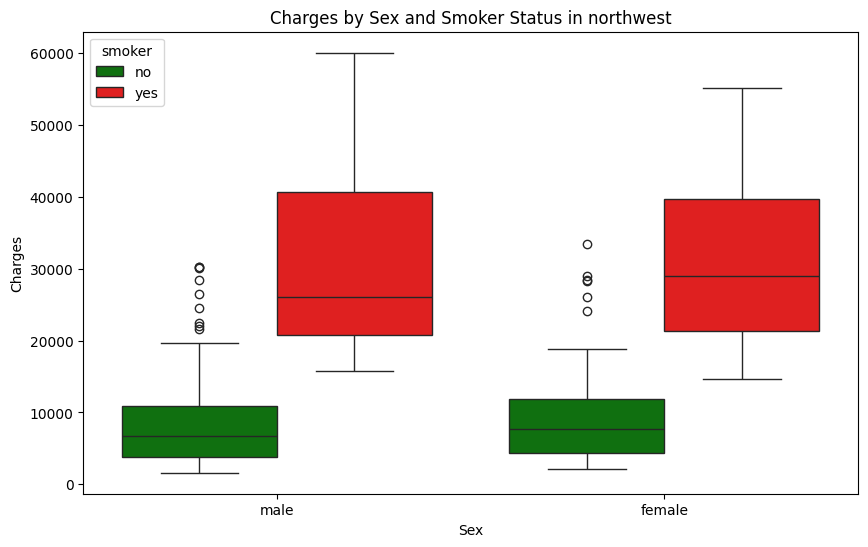

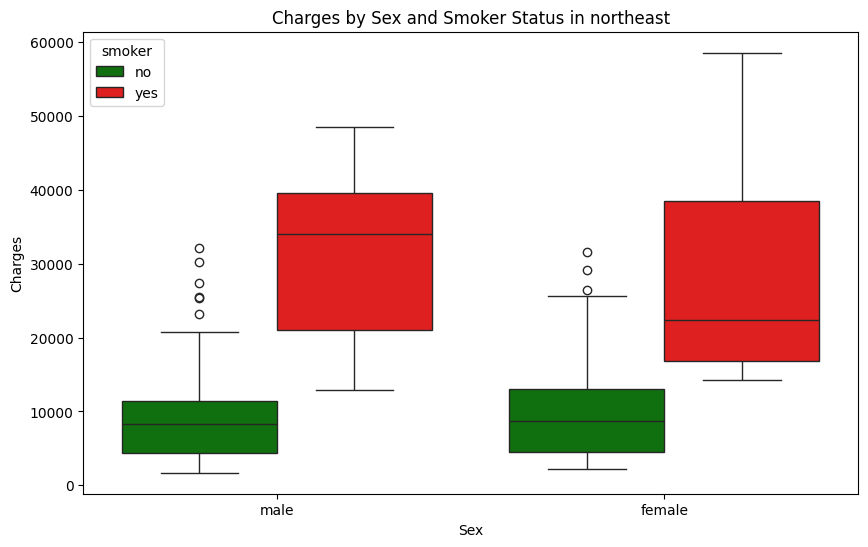

In [34]:
regions = df['region'].unique()
palette = {'yes': 'red', 'no': 'green'}
for region in regions:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='sex', y='charges', hue='smoker', data=df[df['region'] == region], palette=palette)
    plt.xlabel('Sex')
    plt.ylabel('Charges')
    plt.title(f'Charges by Sex and Smoker Status in {region}')
    plt.show()

### Region wise Analysis
- South West
    - Males have higher median and overall higher charges
    - There are few Non Smoker Female Outliers, indicating old age or serious disease
    - Males have Higher Range

- South East
    - Males have higher Range and Median
    - Again female non Smokers Outliers can be seen

- North West
    - Females have Higher Median
    - Males have greater Range
    - Non Smokers Outliers are similar in both

- North East
    - Females clearly have higher Range
    - Males have higher Median
    - Non Smoker Males have higher Outliers

#### Conclusion
- North East is female dominated with higher ranges and comparable median
- North West Females have higher medians
- Southern Region is primarily male dominated with Female outliers indicating Oldage or some Serious Disease


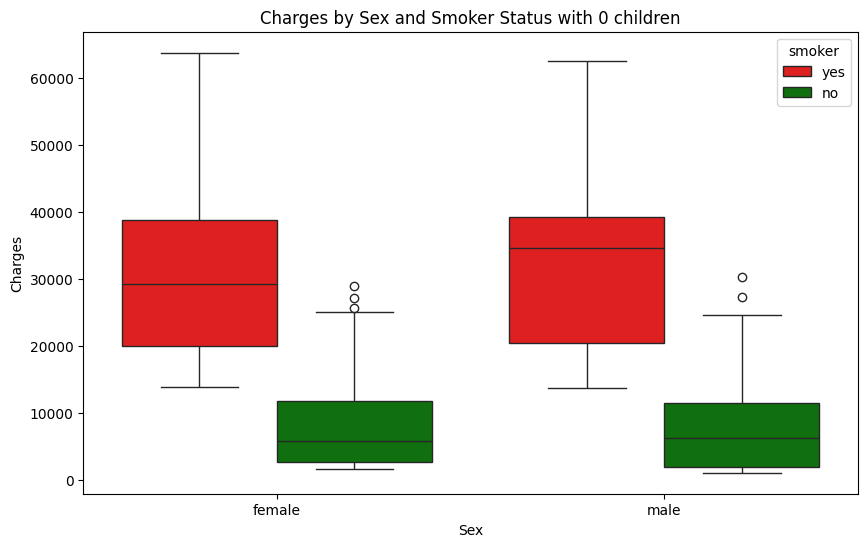

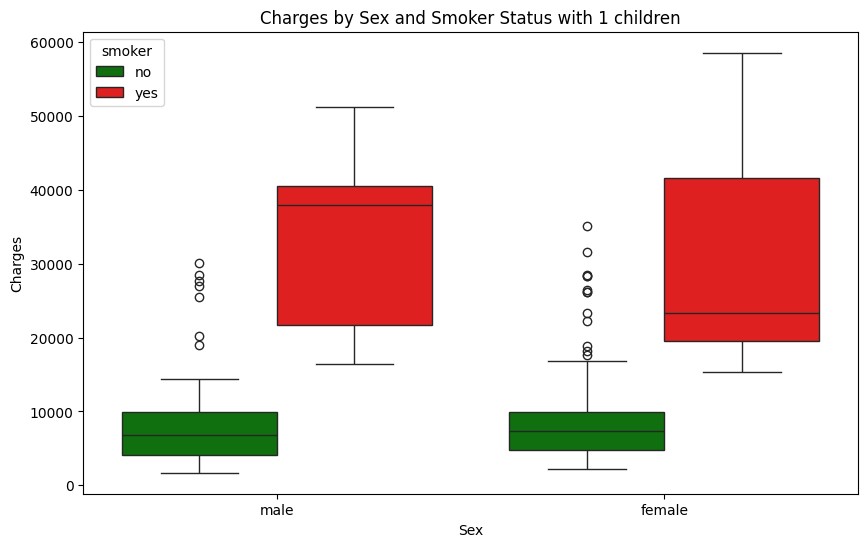

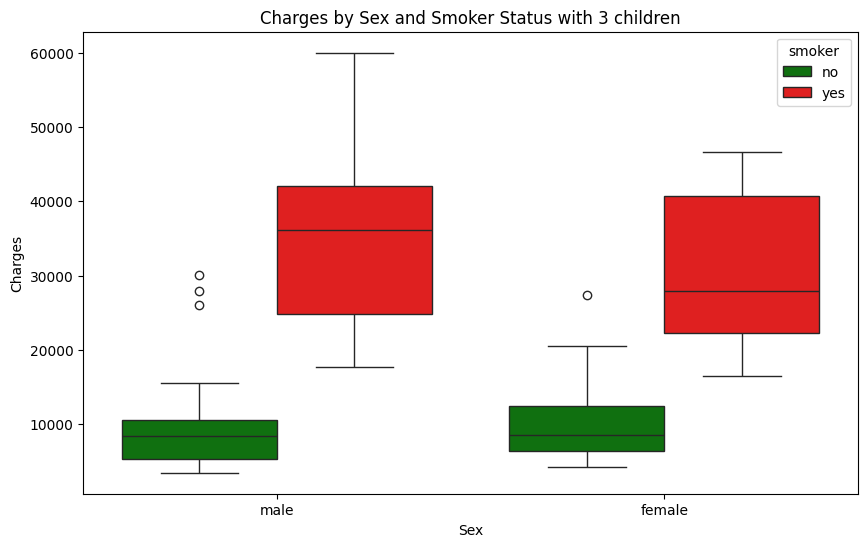

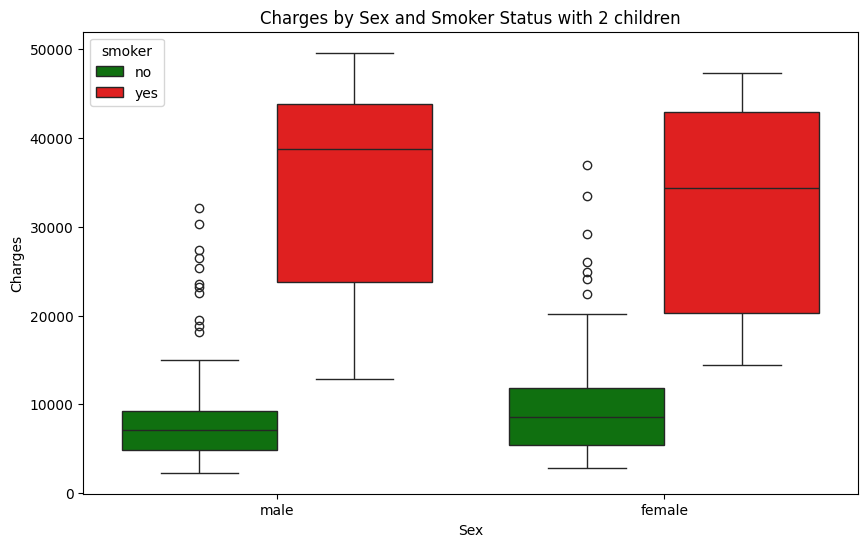

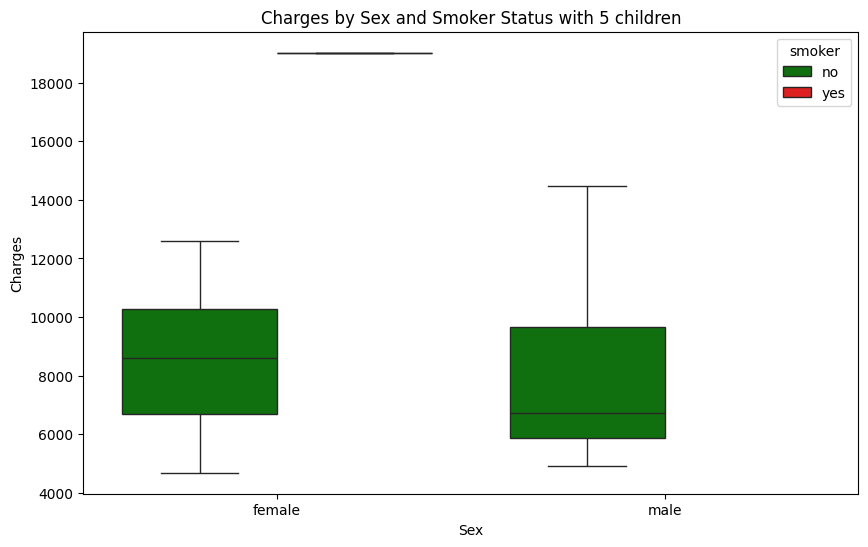

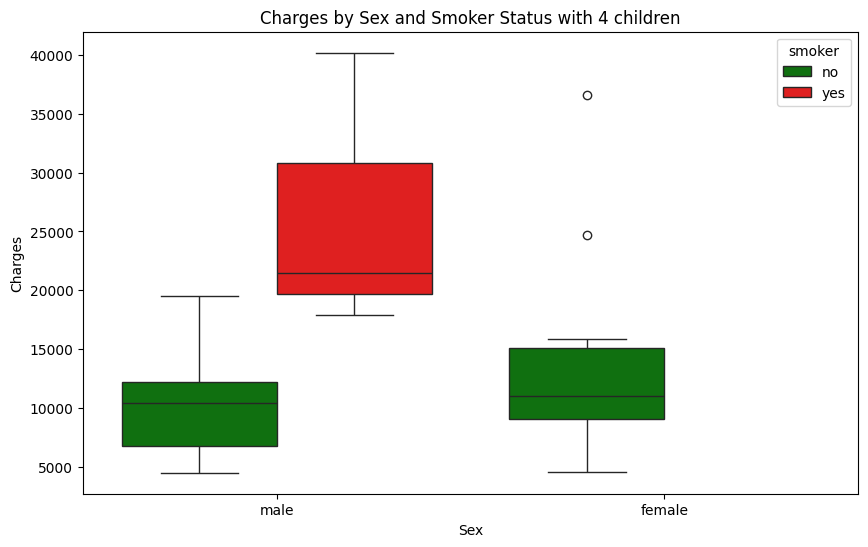

In [48]:
children = df['children'].unique()
palette = {'yes': 'red', 'no': 'green'}
for child in children:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='sex', y='charges', hue='smoker', data=df[df['children'] == child], palette=palette)
    plt.xlabel('Sex')
    plt.ylabel('Charges')
    plt.title(f'Charges by Sex and Smoker Status with {child} children')
    plt.show()

### Analysis wrt Childrens
- 0 Children
    - High Range while males having higher median than females
- 1 Children
    - 2nd Highest Range
    - Smoker males having very high median
- 2 Children
    - Lower Range , but having highest outliers
    - High Male Median
- 3 Children 
    - 3rd Highest Region
    - Males having Higher median and dominates
- 4 children
    - Least Range
    - No Female Smokers
    - High Female Outliers are present
- 5 children
    - No Female Smokers
    - Least Male Smokers
    - No Outliers

In [106]:
df=pd.get_dummies(df, drop_first=True)
df.head()

,age,bmi,children,charges,log_charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,9.734176,False,True,False,False,True
1,18,33.770,1,1725.55230,7.453302,True,False,False,True,False
2,28,33.000,3,4449.46200,8.400538,True,False,False,True,False
3,33,22.705,0,21984.47061,9.998092,True,False,True,False,False
4,32,28.880,0,3866.85520,8.260197,True,False,True,False,False


In [107]:
X=df.drop(['charges','log_charges'], axis=1)
y=df['log_charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [109]:
models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'LinearRegression': LinearRegression(),
    'SVR': SVR()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f'{name} - R²: {r2:.4f}, MSE: {mse:.4f}')

RandomForestRegressor - R²: 0.8440, MSE: 0.1403
DecisionTreeRegressor - R²: 0.7784, MSE: 0.1992
LinearRegression - R²: 0.8047, MSE: 0.1756
SVR - R²: 0.3976, MSE: 0.5417
